In [1]:
import torch
# GPU 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

# CUDA 사용 가능 여부 확인
print(f"CUDA available: {torch.cuda.is_available()}")  # True여야 함

# PyTorch에서 사용하는 CUDA 버전 확인
print(f"CUDA version in PyTorch: {torch.version.cuda}")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda
NVIDIA GeForce RTX 4050 Laptop GPU
CUDA available: True
CUDA version in PyTorch: 11.8


In [2]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

d:\isy\test\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [106]:
import os
import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from torchvision import transforms

# 하이퍼파라미터 설정
BATCH_SIZE = 32
IMAGE_SIZE = 299

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
])

# 데이터세트 디렉토리 설정
ng_dir = '../PCB_imgs/all/resize/NG'  # ng 이미지 폴더 경로
ok_dir = '../PCB_imgs/all/resize/OK'   # ok 이미지 폴더 경로

# ng 폴더 내의 이미지 파일명으로 결함명 추출
ng_images = []
ng_labels = []

# 정규 표현식을 사용하여 파일명에서 결함명 추출
def extract_defect_name(filename):
    # 결함명 추출
    match = re.match(r"([a-zA-Z_]+)(?:\s*\(\d+\)|_\d+)?", filename)  # 'Dust_1.bmp.png'에서 'Dust'만 추출
    if match:
        return match.group(1)
    return filename

# NG 이미지 처리
for img_name in os.listdir(ng_dir):
    if img_name.endswith(('.png')):  # 이미지 파일 확장자 확인
        ng_images.append(os.path.join(ng_dir, img_name))
        ng_labels.append(extract_defect_name(img_name))  # 파일명에서 결함명 추출

# OK 폴더 내의 이미지 파일명으로 라벨 생성 (OK는 일반적으로 'OK'로 표기)
ok_images = [os.path.join(ok_dir, img_name) for img_name in os.listdir(ok_dir) if img_name.endswith(('.png'))]
ok_labels = ['OK'] * len(ok_images)

# 전체 데이터 및 라벨 결합
file_paths = ng_images + ok_images
targets = ng_labels + ok_labels

# 클래스별 이미지 개수 확인
class_counts = Counter(targets)

# 소수 클래스 이미지 우선 분할
minority_classes = [key for key, count in class_counts.items() if count < 10]
print("Minority Classes:", minority_classes)
# minority_images = [(path, label) for path, label in zip(file_paths, targets) if label in minority_classes and label!='chui']
# print("Minority Images:", minority_images)
chui_images = [(path, label) for path, label in zip(file_paths, targets) if label in minority_classes and label=='chui']
nogwang_images = [(path, label) for path, label in zip(file_paths, targets) if label in minority_classes and label=='nogwang']
bichim_images = [(path, label) for path, label in zip(file_paths, targets) if label in minority_classes and label=='bichim']
island_images = [(path, label) for path, label in zip(file_paths, targets) if label in minority_classes and label=='Island_']
pyomyun_images = [(path, label) for path, label in zip(file_paths, targets) if label in minority_classes and label=='pyomyun']

# 나머지 이미지 분할
majority_images = [(path, label) for path, label in zip(file_paths, targets) if label not in ['chui', 'nogwang', 'bichim', 'island', 'pyomyun']]
majority_file_paths, majority_targets = zip(*majority_images)

# 소수 클래스 이미지를 validation과 test 세트에 먼저 분배
# minority_train, minority_val_test = train_test_split(minority_images, test_size=0.2, random_state=124)
# minority_val, minority_test = train_test_split(minority_val_test, test_size=0.5, random_state=124)

# majority 데이터의 90%를 훈련, 나머지 10%를 테스트 데이터로 사용
train_images, test_images, train_targets, test_targets = train_test_split(
    majority_file_paths, majority_targets, stratify=majority_targets, test_size=0.1, random_state=124
)

# train 데이터의 80%는 훈련, 20%는 검증 데이터로 사용
train_images, validation_images, train_targets, validation_targets = train_test_split(
    train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124
)

# # 소수 클래스 이미지 추가
# train_images += [img[0] for img in minority_train]
# train_targets += [img[1] for img in minority_train]

# # validation 세트에 소수 클래스 결함 추가
# for img in minority_val:
#     validation_images.append(img[0])
#     validation_targets.append(img[1])

# # test 세트에 소수 클래스 결함 추가
# for img in minority_test:
#     test_images.append(img[0])
#     test_targets.append(img[1])

# chui (2개)
train_images.append(chui_images[0][0])  # validation에 첫 번째 chui 추가
train_targets.append(chui_images[0][1])
test_images.append(chui_images[1][0])        # test에 두 번째 chui 추가
test_targets.append(chui_images[1][1])

# nogwang (2개)
train_images.append(nogwang_images[0][0]) 
train_targets.append(nogwang_images[0][1])
test_images.append(nogwang_images[1][0])       
test_targets.append(nogwang_images[1][1])

# island (5개)
for i, img in enumerate(island_images):
    if i == 0 or i == 1:  
        train_images.append(img[0])
        train_targets.append(img[1])
    elif i % 2 == 0:  # 인덱스가 짝수일 때는 validation 세트에 추가
        validation_images.append(img[0])
        validation_targets.append(img[1])
    else:  # 인덱스가 홀수일 때는 test 세트에 추가
        test_images.append(img[0])
        test_targets.append(img[1])


# bichim (8개)
for i, img in enumerate(bichim_images):
    if i % 2 == 0:  
        train_images.append(img[0])
        train_targets.append(img[1])
    elif i == 1 or i == 3:  # 인덱스가 짝수일 때는 validation 세트에 추가
        test_images.append(img[0])
        test_targets.append(img[1])
    else:  # 인덱스가 홀수일 때는 test 세트에 추가
        validation_images.append(img[0])
        validation_targets.append(img[1])

# pyomyun (3개)
for i, img in enumerate(pyomyun_images):
    if i == 0:  
        train_images.append(img[0])
        train_targets.append(img[1])
    if i == 1:  # 인덱스가 짝수일 때는 validation 세트에 추가
        validation_images.append(img[0])
        validation_targets.append(img[1])
    else:  # 인덱스가 홀수일 때는 test 세트에 추가
        test_images.append(img[0])
        test_targets.append(img[1])

# 길이 확인
print(f"Train: {len(train_images)}, {len(train_targets)}")
print(f"Validation: {len(validation_images)}, {len(validation_targets)}")
print(f"Test: {len(test_images)}, {len(test_targets)}")

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_images, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': validation_images, 'targets': validation_targets})
test_df = pd.DataFrame({'file_paths': test_images, 'targets': test_targets})

# DataFrame 확인
print("Train DataFrame:")
print(train_df.head())
print("\nValidation DataFrame:")
print(validation_df.head())
print("\nTest DataFrame:")
print(test_df.head())

# DataFrame을 CSV 파일로 저장 (선택적)
train_df.to_csv('train_data.csv', index=False)
validation_df.to_csv('validation_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)


Minority Classes: ['bichim', 'chui', 'Island_', 'LVH', 'nogwang', 'pinhole', 'Pinhole_', 'pyomyun']
Train: 2257, 2257
Validation: 567, 567
Test: 320, 320
Train DataFrame:
                                       file_paths targets
0       ../PCB_imgs/all/resize/NG\Nick_49.bmp.png   Nick_
1        ../PCB_imgs/all/resize/OK\ok_745.bmp.png      OK
2      ../PCB_imgs/all/resize/OK\ok (444).bmp.png      OK
3  ../PCB_imgs/all/resize/NG\eemool (222).bmp.png  eemool
4      ../PCB_imgs/all/resize/OK\ok (640).bmp.png      OK

Validation DataFrame:
                                       file_paths targets
0   ../PCB_imgs/all/resize/NG\eemool (90).bmp.png  eemool
1   ../PCB_imgs/all/resize/NG\miboo (267).bmp.png   miboo
2   ../PCB_imgs/all/resize/NG\eemool1 (9).bmp.png  eemool
3       ../PCB_imgs/all/resize/OK\ok_1308.bmp.png      OK
4  ../PCB_imgs/all/resize/NG\eemool (106).bmp.png  eemool

Test DataFrame:
                                    file_paths targets
0   ../PCB_imgs/all/resize/OK\ok (481)

In [107]:
import os
import shutil

# 데이터 세트 디렉토리 설정
base_dir = '../PCB_imgs/resplit'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# NG와 OK 폴더 생성 (존재하지 않는 경우)
os.makedirs(os.path.join(train_dir, 'NG'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'OK'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'NG'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'OK'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'NG'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'OK'), exist_ok=True)

# NG와 OK 이미지를 각기 다른 디렉토리로 복사
for idx, row in train_df.iterrows():
    if row['targets'] != 'OK':  # 결함명에 따라 NG로 변경
        shutil.copy(row['file_paths'], os.path.join(train_dir, 'NG', f"{idx}.png"))
    else:
        shutil.copy(row['file_paths'], os.path.join(train_dir, 'OK', f"{idx}.png"))

for idx, row in validation_df.iterrows():
    if row['targets'] != 'OK':  # 결함명에 따라 NG로 변경
        shutil.copy(row['file_paths'], os.path.join(validation_dir, 'NG', f"{idx}.png"))
    else:
        shutil.copy(row['file_paths'], os.path.join(validation_dir, 'OK', f"{idx}.png"))

for idx, row in test_df.iterrows():
    if row['targets'] != 'OK':  # 결함명에 따라 NG로 변경
        shutil.copy(row['file_paths'], os.path.join(test_dir, 'NG', f"{idx}.png"))
    else:
        shutil.copy(row['file_paths'], os.path.join(test_dir, 'OK', f"{idx}.png"))

print("이미지 복사가 완료되었습니다.")

이미지 복사가 완료되었습니다.


In [3]:
from torchvision import datasets
import pandas as pd

IMAGE_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 10

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
])

# 데이터셋 디렉토리 설정
train_dir = '../PCB_imgs/resplit/train'
val_dir = '../PCB_imgs/resplit/validation'
test_dir = '../PCB_imgs/resplit/test'

# ImageFolder로 데이터셋 불러오기
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# 파일 경로 및 타겟 추출
train_file_paths = [img[0] for img in train_dataset.imgs]
train_targets = train_dataset.targets

val_file_paths = [img[0] for img in val_dataset.imgs]
val_targets = val_dataset.targets

test_file_paths = [img[0] for img in test_dataset.imgs]
test_targets = test_dataset.targets

# 타겟 반전 (NG: 1, OK: 0)
train_targets = [1 if target == 0 else 0 for target in train_targets]
val_targets = [1 if target == 0 else 0 for target in val_targets]
test_targets = [1 if target == 0 else 0 for target in test_targets]

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_file_paths, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': val_file_paths, 'targets': val_targets})
test_df = pd.DataFrame({'file_paths': test_file_paths, 'targets': test_targets})

# 확인을 위해 각 데이터셋의 크기 출력
print(f"Train 데이터 수: {len(train_df)}")
print(f"Validation 데이터 수: {len(validation_df)}")
print(f"Test 데이터 수: {len(test_df)}")

Train 데이터 수: 2257
Validation 데이터 수: 567
Test 데이터 수: 320


In [4]:
import torch
from torchvision import datasets, transforms

# resize된 데이터셋 로드
input_dir = '../PCB_imgs/resplit/'
dataset = datasets.ImageFolder(root=input_dir, transform=transform)

# 데이터 로더 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 로더에서 데이터 가져오기
for images, labels in dataloader:
    print(images.shape)  # 배치의 이미지 텐서 크기 확인
    break  # 첫 번째 배치만 확인
    # 배치 크기, 채널 수(RGB), 이미지 크기 

torch.Size([32, 3, 299, 299])


In [5]:
IMAGE_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 10

# 커스텀 데이터세트 정의
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        if self.aug is not None:
            image = self.aug(image=image)['image']

        if self.preprocess is not None:
            image = self.preprocess(image)

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        
        return image, target

In [6]:
# 평가 함수 정의
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            outputs = outputs.view(-1) # torch.Size([batch_size])로 변환
            loss = criterion(outputs, labels)  # 손실 계산
            running_test_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # 0.5 기준으로 이진 분류
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    # 검증 손실과 정확도
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test
    return test_loss, test_accuracy

##### inception + imagenet + 증강 + dropout layer 추가 + fc layer 추가
초기학습률 0.0001  
Adam optimizer 사용  
20 epoch (early stop: p=3, 학습률 스케줄러)

In [24]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
import torch
import torch.nn as nn
import torchvision

class CustomModel(nn.Module):
    def __init__(self, model_name='efficientnet'):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet':
            self.base_model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.fc = nn.Identity()  # 마지막 분류기 제거

        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.fc2 = nn.Linear(50, 1)  # Sigmoid 출력

    def _get_features_dim(self, model_name):
        if model_name == 'efficientnet':
            return 1280  # EfficientNet B0의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'inception':
            return 2048  # Inception의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        if isinstance(x, tuple):  
            x = x[0]  
        
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)  # Dropout을 두 번 사용
        x = self.fc2(x)
        return x

In [26]:
# 모델 초기화
model = CustomModel(model_name='inception').to(DEVICE)
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [27]:
EPOCHS = 20

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 3  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")  
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/inception_re_best_model_04.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/20], Train Loss: 0.4709, Train Accuracy: 0.7736, Val Loss: 0.3527, Val Accuracy: 0.8466
Validation loss improved, saving model...
Epoch [2/20], Train Loss: 0.2911, Train Accuracy: 0.8795, Val Loss: 0.2254, Val Accuracy: 0.9136
Validation loss improved, saving model...
Epoch [3/20], Train Loss: 0.1871, Train Accuracy: 0.9300, Val Loss: 0.1615, Val Accuracy: 0.9330
Validation loss improved, saving model...
Epoch [4/20], Train Loss: 0.1033, Train Accuracy: 0.9681, Val Loss: 0.1269, Val Accuracy: 0.9612
Validation loss improved, saving model...
Epoch [5/20], Train Loss: 0.0895, Train Accuracy: 0.9721, Val Loss: 0.0945, Val Accuracy: 0.9665
Validation loss improved, saving model...
Epoch [6/20], Train Loss: 0.0613, Train Accuracy: 0.9805, Val Loss: 0.0867, Val Accuracy: 0.9753
Epoch [7/20], Train Loss: 0.0680, Train Accuracy: 0.9774, Val Loss: 0.1349, Val Accuracy: 0.9577
Validation loss improved, saving model...
Epoch [8/20], Train Loss: 0

In [30]:
# 모델 클래스 정의 (CustomModel)
model = CustomModel(model_name='inception').to(DEVICE)

# 저장된 체크포인트 불러오기
checkpoint = torch.load('../model/inception_re_best_model_04.pth')

# 모델에 체크포인트 적용
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

# 모델을 평가 모드로 전환
model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_12792\92610835.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/inception_re_best_model_04.

CustomModel(
  (base_model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): 

In [31]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0914, Test Accuracy: 0.9781


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation(y_test, prediction):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 75)

    # 오차 행렬 시각화
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    
    # 일반 오차 행렬
    disp = ConfusionMatrixDisplay(confusion)
    disp.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title('Confusion Matrix')

    # 정규화된 오차 행렬
    normalized_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]  # 정규화
    disp_normalized = ConfusionMatrixDisplay(normalized_confusion)
    disp_normalized.plot(ax=axes[1], cmap=plt.cm.Blues)
    axes[1].set_title('Normalized Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
import numpy as np
import torch

# 정밀도-재현율 곡선 그리기 함수
def precision_recall_curve_plot(y_test, prediction_proba_class1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, prediction_proba_class1)
    
    # 그래프 크기 설정
    plt.figure(figsize=(8, 6))
    
    # 정밀도와 재현율 플롯
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='Precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='Recall')
    
    # X축(threshold)의 Scale을 0 ~ 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
from sklearn.metrics import precision_recall_curve
import torch
import numpy as np

# 모델이 예측한 확률 값을 얻는 함수
def get_predictions_proba(model, test_loader):
    model.eval()
    all_predictions_proba = []
    all_targets = []
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, targets in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            
            # 예측 확률 계산 (sigmoid로 확률 변환)
            predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
            all_predictions_proba.extend(predicted_proba)
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_predictions_proba), np.array(all_targets)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation_no_pic(y_test, prediction):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 75)

In [11]:
from sklearn.preprocessing import Binarizer

def get_evaluation_by_thresholds(y_test, prediction_proba_class1, thresholds):
    for threshold in thresholds:
        # Binarizer로 예측값을 이진화
        binarizer = Binarizer(threshold=threshold).fit(prediction_proba_class1) 
        custom_prediction = binarizer.transform(prediction_proba_class1).flatten()  # 차원 축소
        
        print('임곗값:', threshold)
        get_evaluation_no_pic(y_test, custom_prediction)  # 평가 함수 호출

In [12]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt

# 평가 함수
def get_evaluation_by_custom_proba(y_test, prediction, visualize=False):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, ROC-AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 80)
    
    if visualize:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]
        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_predictions(y_test, prediction, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[126   4]
 [  3 187]]
정확도: 0.9781, 정밀도: 0.9791, 재현율: 0.9842, F1:0.9816, AUC:0.9767
###########################################################################


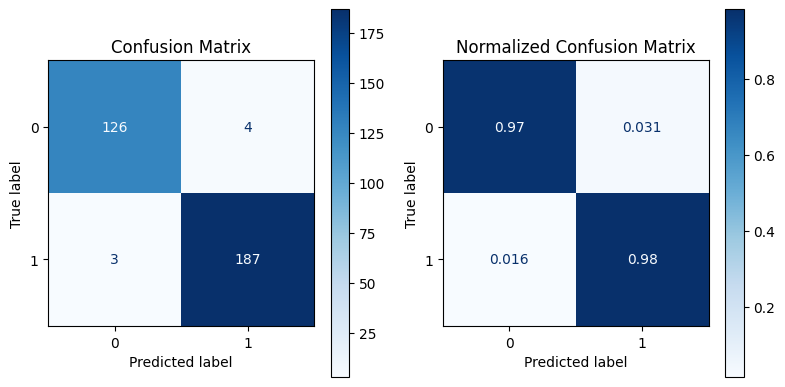

In [32]:
# 테스트 데이터에 대한 예측 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions = []
all_targets = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        outputs = model(images)

        # 예측 결과 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 이진 분류 기준으로 확률 임계값 설정

        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장
        all_targets.extend(targets.cpu().numpy())  # 실제 레이블 저장

# 리스트를 numpy 배열로 변환
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# 평가 함수 호출
get_evaluation(all_targets, all_predictions)

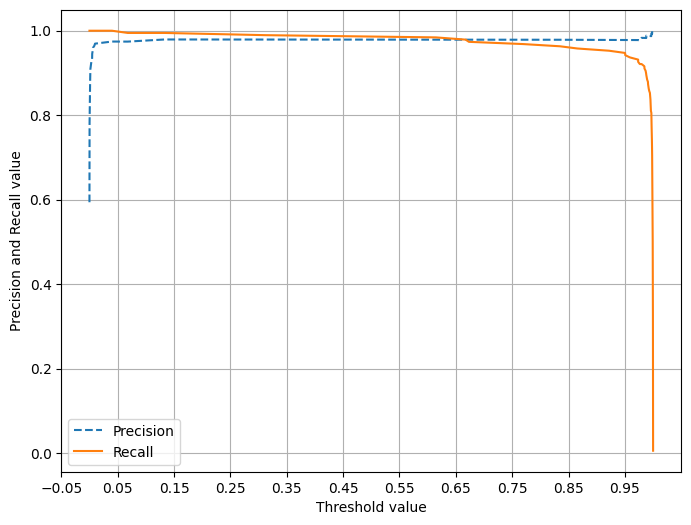

In [33]:
# 테스트 데이터에 대한 예측 확률 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 정밀도-재현율 곡선 그리기
precision_recall_curve_plot(all_targets, all_predictions_proba)

In [34]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 정밀도-재현율 곡선과 임계값 계산
precisions, recalls, thresholds = precision_recall_curve(all_targets, all_predictions_proba)

# 임계값 확인
print(thresholds)

[1.5084453e-07 2.3349067e-07 4.9324484e-07 7.2810133e-07 1.0442087e-06
 1.5572031e-06 1.8250513e-06 2.2758372e-06 2.4724834e-06 2.5111106e-06
 2.6467724e-06 2.8402405e-06 2.9642408e-06 3.5095254e-06 3.8053338e-06
 4.0524287e-06 4.5372863e-06 5.2168407e-06 5.2235619e-06 5.7171528e-06
 8.7781245e-06 9.2424625e-06 9.8678811e-06 1.0777421e-05 1.1696405e-05
 1.1724246e-05 1.3651497e-05 1.5241830e-05 1.5403297e-05 1.6445740e-05
 1.6718839e-05 1.6902915e-05 1.8068975e-05 1.8142322e-05 1.8528213e-05
 1.8571875e-05 1.8730925e-05 2.0485426e-05 2.0786023e-05 2.3396338e-05
 2.3540604e-05 2.4384392e-05 2.7525582e-05 2.9687975e-05 3.0709780e-05
 3.1693133e-05 3.1973177e-05 3.2159718e-05 3.3316566e-05 3.8036487e-05
 3.9598955e-05 3.9900464e-05 4.1497682e-05 4.3586813e-05 4.3787160e-05
 4.7246802e-05 5.0437229e-05 5.1087827e-05 5.3034957e-05 5.4673052e-05
 5.5302869e-05 5.7209414e-05 6.2883206e-05 8.1726284e-05 9.0014160e-05
 9.5334697e-05 1.0881210e-04 1.1649157e-04 1.2535795e-04 1.3192858e-04
 1.370

In [35]:
# 테스트 데이터에 대한 예측 확률을 계산
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 임계값에 따른 평가 수행
get_evaluation_by_thresholds(all_targets, all_predictions_proba.reshape(-1, 1), thresholds)

임곗값: 1.5084453e-07
오차 행렬
[[  1 129]
 [  0 190]]
정확도: 0.5969, 정밀도: 0.5956, 재현율: 1.0000, F1:0.7466, AUC:0.5038
###########################################################################
임곗값: 2.3349067e-07
오차 행렬
[[  2 128]
 [  0 190]]
정확도: 0.6000, 정밀도: 0.5975, 재현율: 1.0000, F1:0.7480, AUC:0.5077
###########################################################################
임곗값: 4.9324484e-07
오차 행렬
[[  3 127]
 [  0 190]]
정확도: 0.6031, 정밀도: 0.5994, 재현율: 1.0000, F1:0.7495, AUC:0.5115
###########################################################################
임곗값: 7.281013e-07
오차 행렬
[[  4 126]
 [  0 190]]
정확도: 0.6062, 정밀도: 0.6013, 재현율: 1.0000, F1:0.7510, AUC:0.5154
###########################################################################
임곗값: 1.0442087e-06
오차 행렬
[[  5 125]
 [  0 190]]
정확도: 0.6094, 정밀도: 0.6032, 재현율: 1.0000, F1:0.7525, AUC:0.5192
###########################################################################
임곗값: 1.5572031e-06
오차 행렬
[[  6 124]
 [  0 190]]
정확도: 0.6125, 정밀도: 0.6051, 재현

d:\isy\test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차 행렬
[[126   4]
 [  1 189]]
정확도: 0.9844, 정밀도: 0.9793, 재현율: 0.9947, F1: 0.9869, ROC-AUC: 0.9820
################################################################################


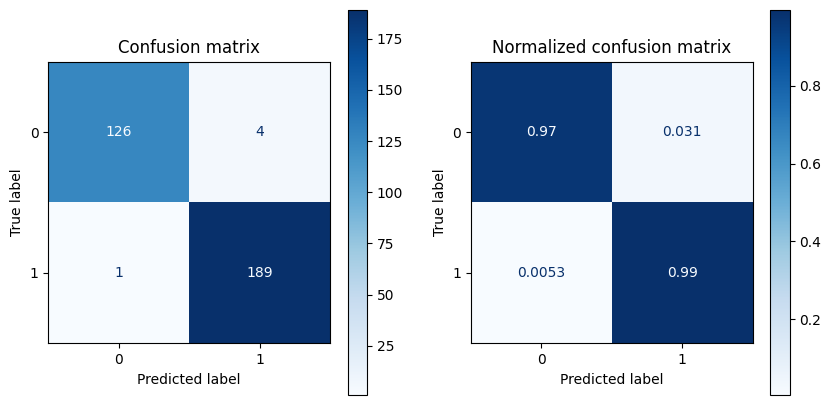

In [36]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 임계값 설정 및 이진 분류
threshold = 0.06795997
binarizer = Binarizer(threshold=threshold)
custom_prediction = binarizer.fit_transform(all_predictions_proba.reshape(-1, 1)).flatten()

# 평가 함수 호출
get_evaluation_by_custom_proba(all_targets, custom_prediction, visualize=True)

##### fine tuning

In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
class CustomModel(nn.Module):
    def __init__(self, model_name='efficientnet'):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet':
            self.base_model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.AuxLogits = nn.Identity()  # Auxiliary logit 제거
            self.base_model.fc = nn.Identity()  # 마지막 분류기 제거

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.fc2 = nn.Linear(50, 1)  # Sigmoid 출력

    def _get_features_dim(self, model_name):
        if model_name == 'efficientnet':
            return 1280  # EfficientNet B0의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'inception':
            return 2048  # Inception의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        if isinstance(x, tuple): 
            x = x[0]  # Inception 모델의 경우, tuple에서 첫 번째 요소 추출
        
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [15]:
# 모델 생성
model = CustomModel(model_name='inception').to(DEVICE)

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. BatchNorm 층만 동결, 나머지는 동결 해제
for name, param in model.base_model.named_parameters():
    if "bn" in name.lower(): 
        param.requires_grad = False
    else:
        param.requires_grad = True  

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.Conv2d_1a_3x3.conv.weight | Requires Grad: True
Layer: base_model.Conv2d_1a_3x3.bn.weight | Requires Grad: False
Layer: base_model.Conv2d_1a_3x3.bn.bias | Requires Grad: False
Layer: base_model.Conv2d_2a_3x3.conv.weight | Requires Grad: True
Layer: base_model.Conv2d_2a_3x3.bn.weight | Requires Grad: False
Layer: base_model.Conv2d_2a_3x3.bn.bias | Requires Grad: False
Layer: base_model.Conv2d_2b_3x3.conv.weight | Requires Grad: True
Layer: base_model.Conv2d_2b_3x3.bn.weight | Requires Grad: False
Layer: base_model.Conv2d_2b_3x3.bn.bias | Requires Grad: False
Layer: base_model.Conv2d_3b_1x1.conv.weight | Requires Grad: True
Layer: base_model.Conv2d_3b_1x1.bn.weight | Requires Grad: False
Layer: base_model.Conv2d_3b_1x1.bn.bias | Requires Grad: False
Layer: base_model.Conv2d_4a_3x3.conv.weight | Requires Grad: True
Layer: base_model.Conv2d_4a_3x3.bn.weight | Requires Grad: False
Layer: base_model.Conv2d_4a_3x3.bn.bias | Requires Grad: False
Layer: base_model.Mixed_5b.bra

In [16]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")  
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/inception_re_ft_best_model_01.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.4584, Train Accuracy: 0.7718, Val Loss: 0.3160, Val Accuracy: 0.8660
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.2917, Train Accuracy: 0.8835, Val Loss: 0.2670, Val Accuracy: 0.8995
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.2220, Train Accuracy: 0.9171, Val Loss: 0.2506, Val Accuracy: 0.9065
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.1695, Train Accuracy: 0.9437, Val Loss: 0.1878, Val Accuracy: 0.9259
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.1303, Train Accuracy: 0.9646, Val Loss: 0.1405, Val Accuracy: 0.9506
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.0997, Train Accuracy: 0.9734, Val Loss: 0.1181, Val Accuracy: 0.9647
Validation loss improved, saving model...
Epoch [7/50], Train Loss: 0.0835, Train Accuracy: 0.9783, Val Loss: 0.0964, Val Accuracy: 0.9718
Epoch [8/50], Train Loss: 0

In [17]:
# 모델 클래스 정의 (CustomModel)
model = CustomModel(model_name='inception').to(DEVICE)

# 저장된 체크포인트 불러오기
checkpoint = torch.load('../model/inception_re_ft_best_model_01.pth')

# 모델에 체크포인트 적용
model.load_state_dict(checkpoint['model_state_dict'])

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. BatchNorm 층만 동결, 나머지는 동결 해제
for name, param in model.base_model.named_parameters():
    if "bn" in name.lower(): 
        param.requires_grad = False
    else:
        param.requires_grad = True  

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

# 에포크 정보 가져오기 (옵션)
start_epoch = checkpoint['epoch']

# 모델을 평가 모드로 전환
model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_12792\2990453076.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/inception_re_ft_best_mode

CustomModel(
  (base_model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): 

In [18]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.0945, Test accuracy: 0.9781


오차 행렬
[[125   5]
 [  2 188]]
정확도: 0.9781, 정밀도: 0.9741, 재현율: 0.9895, F1:0.9817, AUC:0.9755
###########################################################################


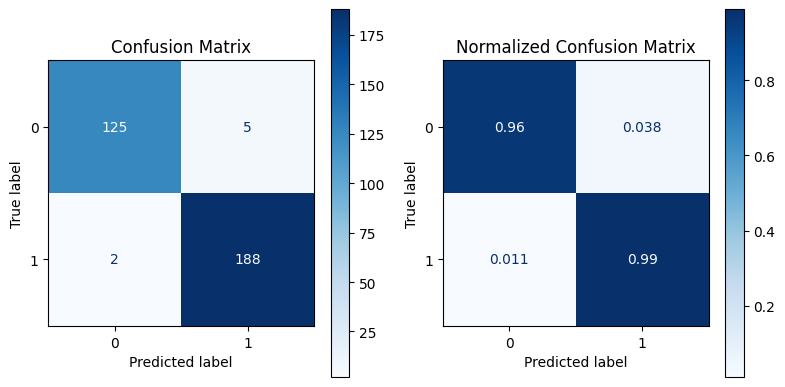

In [19]:
# 테스트 데이터에 대한 예측 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions = []
all_targets = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        outputs = model(images)

        # 예측 결과 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 이진 분류 기준으로 확률 임계값 설정

        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장
        all_targets.extend(targets.cpu().numpy())  # 실제 레이블 저장

# 리스트를 numpy 배열로 변환
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# 평가 함수 호출
get_evaluation(all_targets, all_predictions)

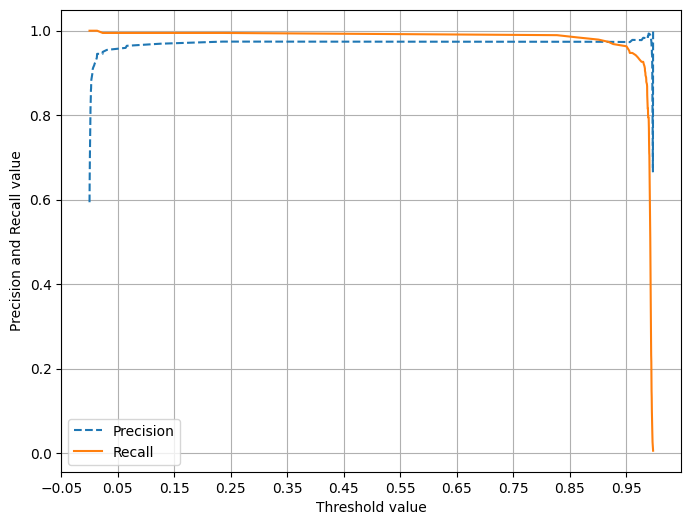

In [20]:
# 테스트 데이터에 대한 예측 확률 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 정밀도-재현율 곡선 그리기
precision_recall_curve_plot(all_targets, all_predictions_proba)

In [21]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 정밀도-재현율 곡선과 임계값 계산
precisions, recalls, thresholds = precision_recall_curve(all_targets, all_predictions_proba)

# 임계값 확인
print(thresholds)

[6.1532455e-06 6.1937276e-06 1.2321559e-05 2.0198651e-05 3.0140813e-05
 3.8349790e-05 4.1082589e-05 4.2495591e-05 4.7455513e-05 4.7760197e-05
 6.0966802e-05 6.2497907e-05 7.0727503e-05 7.4372459e-05 8.7547982e-05
 1.1271824e-04 1.2269517e-04 1.2857078e-04 1.7317057e-04 1.8908156e-04
 1.9969237e-04 2.0001574e-04 2.0296779e-04 2.1072949e-04 2.1965934e-04
 2.3383151e-04 2.6643949e-04 2.8338307e-04 3.0120360e-04 3.2083798e-04
 3.2357895e-04 3.2970888e-04 3.4884791e-04 3.4976855e-04 3.5075244e-04
 3.5089892e-04 3.6196460e-04 4.0418530e-04 4.0744685e-04 4.0946717e-04
 4.4466276e-04 4.4581192e-04 4.4598235e-04 4.4755856e-04 4.9992115e-04
 5.2886386e-04 5.3112529e-04 5.4297911e-04 6.1599800e-04 6.4473861e-04
 6.6629640e-04 6.8075804e-04 7.5174897e-04 7.6632720e-04 7.7471376e-04
 7.9784176e-04 8.3290011e-04 8.4628782e-04 9.1823115e-04 9.3990227e-04
 9.8087848e-04 1.0070556e-03 1.0269892e-03 1.0274750e-03 1.0623726e-03
 1.0880807e-03 1.0905172e-03 1.1173376e-03 1.1200454e-03 1.1767828e-03
 1.191

In [22]:
# 테스트 데이터에 대한 예측 확률을 계산
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 임계값에 따른 평가 수행
get_evaluation_by_thresholds(all_targets, all_predictions_proba.reshape(-1, 1), thresholds)

임곗값: 6.1532455e-06
오차 행렬
[[  1 129]
 [  0 190]]
정확도: 0.5969, 정밀도: 0.5956, 재현율: 1.0000, F1:0.7466, AUC:0.5038
###########################################################################
임곗값: 6.1937276e-06
오차 행렬
[[  2 128]
 [  0 190]]
정확도: 0.6000, 정밀도: 0.5975, 재현율: 1.0000, F1:0.7480, AUC:0.5077
###########################################################################
임곗값: 1.2321559e-05
오차 행렬
[[  3 127]
 [  0 190]]
정확도: 0.6031, 정밀도: 0.5994, 재현율: 1.0000, F1:0.7495, AUC:0.5115
###########################################################################
임곗값: 2.0198651e-05
오차 행렬
[[  4 126]
 [  0 190]]
정확도: 0.6062, 정밀도: 0.6013, 재현율: 1.0000, F1:0.7510, AUC:0.5154
###########################################################################
임곗값: 3.0140813e-05
오차 행렬
[[  5 125]
 [  0 190]]
정확도: 0.6094, 정밀도: 0.6032, 재현율: 1.0000, F1:0.7525, AUC:0.5192
###########################################################################
임곗값: 3.834979e-05
오차 행렬
[[  6 124]
 [  0 190]]
정확도: 0.6125, 정밀도: 0.6051, 재현

d:\isy\test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차 행렬
[[125   5]
 [  1 189]]
정확도: 0.9812, 정밀도: 0.9742, 재현율: 0.9947, F1: 0.9844, ROC-AUC: 0.9781
################################################################################


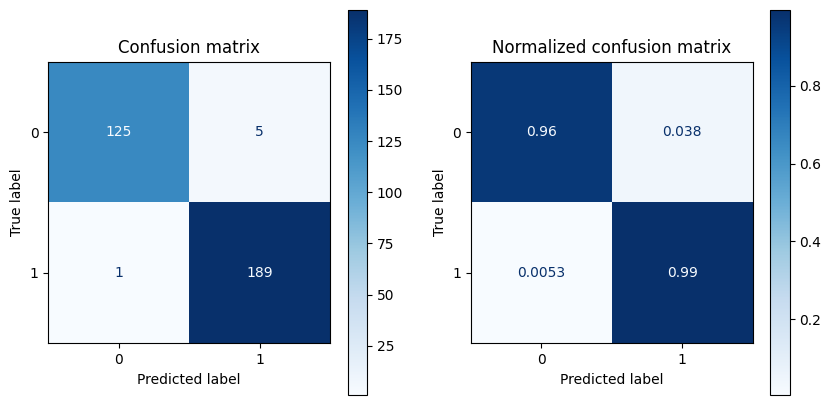

In [23]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 임계값 설정 및 이진 분류
threshold = 0.12530257
binarizer = Binarizer(threshold=threshold)
custom_prediction = binarizer.fit_transform(all_predictions_proba.reshape(-1, 1)).flatten()

# 평가 함수 호출
get_evaluation_by_custom_proba(all_targets, custom_prediction, visualize=True)

In [134]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")  
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/inception_re_ft_best_model_02.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.4661, Train Accuracy: 0.7709, Val Loss: 0.3211, Val Accuracy: 0.8730
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.2948, Train Accuracy: 0.8839, Val Loss: 0.2329, Val Accuracy: 0.9101
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.2122, Train Accuracy: 0.9278, Val Loss: 0.2040, Val Accuracy: 0.9330
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.1498, Train Accuracy: 0.9650, Val Loss: 0.1278, Val Accuracy: 0.9594
Epoch [5/50], Train Loss: 0.1164, Train Accuracy: 0.9677, Val Loss: 0.1795, Val Accuracy: 0.9400
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.1037, Train Accuracy: 0.9725, Val Loss: 0.0922, Val Accuracy: 0.9771
Epoch [7/50], Train Loss: 0.0758, Train Accuracy: 0.9814, Val Loss: 0.0927, Val Accuracy: 0.9788
Epoch [8/50], Train Loss: 0.0631, Train Accuracy: 0.9867, Val Loss: 0.0937, Val Accuracy: 0.9735
Validation los

In [135]:
# 모델 클래스 정의 (CustomModel)
model = CustomModel(model_name='inception').to(DEVICE)

# 저장된 체크포인트 불러오기
checkpoint = torch.load('../model/inception_re_ft_best_model_02.pth')

# 모델에 체크포인트 적용
model.load_state_dict(checkpoint['model_state_dict'])

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. BatchNorm 층만 동결, 나머지는 동결 해제
for name, param in model.base_model.named_parameters():
    if "bn" in name.lower(): 
        param.requires_grad = False
    else:
        param.requires_grad = True  

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

# 에포크 정보 가져오기 (옵션)
start_epoch = checkpoint['epoch']

# 모델을 평가 모드로 전환
model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_14624\2988941156.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/inception_re_ft_best_mode

CustomModel(
  (base_model): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): 

In [136]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0654, Test Accuracy: 0.9812


오차 행렬
[[189   1]
 [  5 125]]
정확도: 0.9812, 정밀도: 0.9921, 재현율: 0.9615, F1:0.9766, AUC:0.9781
###########################################################################


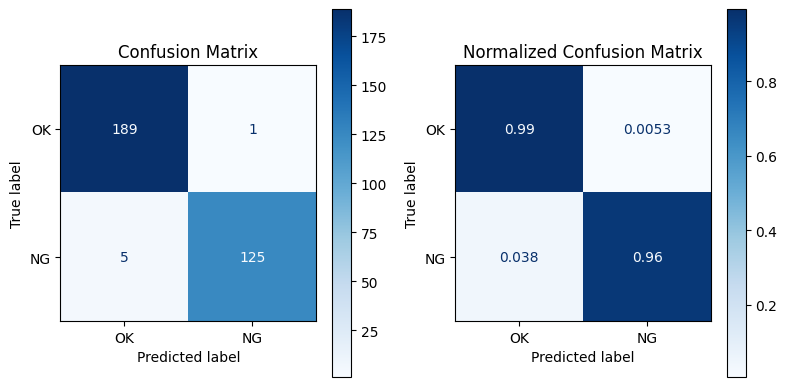

In [137]:
# 테스트 데이터에 대한 예측 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions = []
all_targets = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        outputs = model(images)

        # 예측 결과 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 이진 분류 기준으로 확률 임계값 설정

        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장
        all_targets.extend(targets.cpu().numpy())  # 실제 레이블 저장

# 리스트를 numpy 배열로 변환
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# 평가 함수 호출
get_evaluation(all_targets, all_predictions)

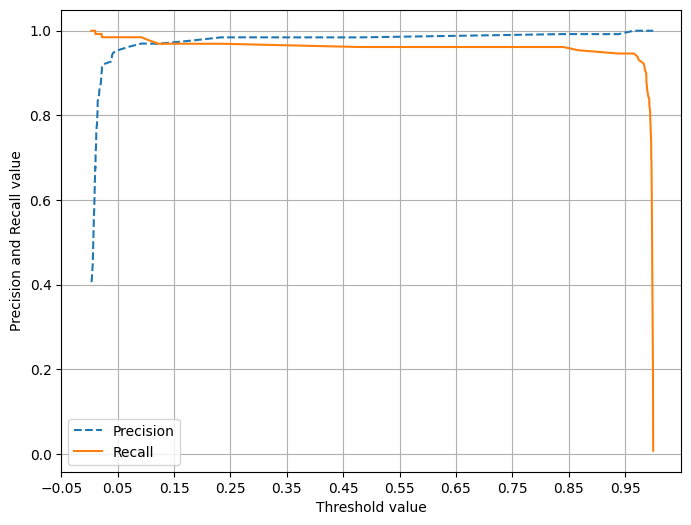

In [138]:
# 테스트 데이터에 대한 예측 확률 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 정밀도-재현율 곡선 그리기
precision_recall_curve_plot(all_targets, all_predictions_proba)

In [139]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 정밀도-재현율 곡선과 임계값 계산
precisions, recalls, thresholds = precision_recall_curve(all_targets, all_predictions_proba)

# 임계값 확인
print(thresholds)

[0.00334731 0.00370784 0.00390429 0.00391529 0.00400939 0.00412824
 0.00424947 0.00429681 0.00440865 0.00443058 0.00443359 0.00445971
 0.00449072 0.00452881 0.0046545  0.00471092 0.00473338 0.0047877
 0.00490955 0.00497082 0.00512093 0.00528209 0.00528686 0.00530716
 0.00530724 0.00534467 0.00538266 0.00559849 0.00573696 0.00575917
 0.00578095 0.00579248 0.00582057 0.00586119 0.00587354 0.00587736
 0.00588101 0.00589492 0.00603791 0.00608208 0.00612225 0.00614456
 0.00620907 0.00624187 0.00626106 0.00626981 0.00631251 0.00636484
 0.00637791 0.0063985  0.0064055  0.0064272  0.00643402 0.00645269
 0.00654446 0.00657681 0.00660199 0.00666531 0.00670801 0.00673459
 0.00675269 0.00679006 0.00686666 0.00698456 0.00700681 0.00701773
 0.00702258 0.00704772 0.00705553 0.00709695 0.00716557 0.00717405
 0.0072065  0.00721184 0.00727921 0.00728424 0.00736911 0.00744853
 0.00749849 0.00752163 0.00755524 0.00760935 0.00761085 0.00766744
 0.00767182 0.00767872 0.0076798  0.00795567 0.00795859 0.00797

In [140]:
# 테스트 데이터에 대한 예측 확률을 계산
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 임계값에 따른 평가 수행
get_evaluation_by_thresholds(all_targets, all_predictions_proba.reshape(-1, 1), thresholds)

임곗값: 0.0033473086
오차 행렬
[[  1 189]
 [  0 130]]
정확도: 0.4094, 정밀도: 0.4075, 재현율: 1.0000, F1:0.5791, AUC:0.5026
###########################################################################
임곗값: 0.0037078375
오차 행렬
[[  2 188]
 [  0 130]]
정확도: 0.4125, 정밀도: 0.4088, 재현율: 1.0000, F1:0.5804, AUC:0.5053
###########################################################################
임곗값: 0.0039042854
오차 행렬
[[  3 187]
 [  0 130]]
정확도: 0.4156, 정밀도: 0.4101, 재현율: 1.0000, F1:0.5817, AUC:0.5079
###########################################################################
임곗값: 0.0039152866
오차 행렬
[[  4 186]
 [  0 130]]
정확도: 0.4188, 정밀도: 0.4114, 재현율: 1.0000, F1:0.5830, AUC:0.5105
###########################################################################
임곗값: 0.0040093907
오차 행렬
[[  5 185]
 [  0 130]]
정확도: 0.4219, 정밀도: 0.4127, 재현율: 1.0000, F1:0.5843, AUC:0.5132
###########################################################################
임곗값: 0.004128242
오차 행렬
[[  6 184]
 [  0 130]]
정확도: 0.4250, 정밀도: 0.4140, 재현율: 1.0

d:\isy\test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차 행렬
[[186   4]
 [  2 128]]
정확도: 0.9812, 정밀도: 0.9697, 재현율: 0.9846, F1: 0.9771, ROC-AUC: 0.9818
################################################################################


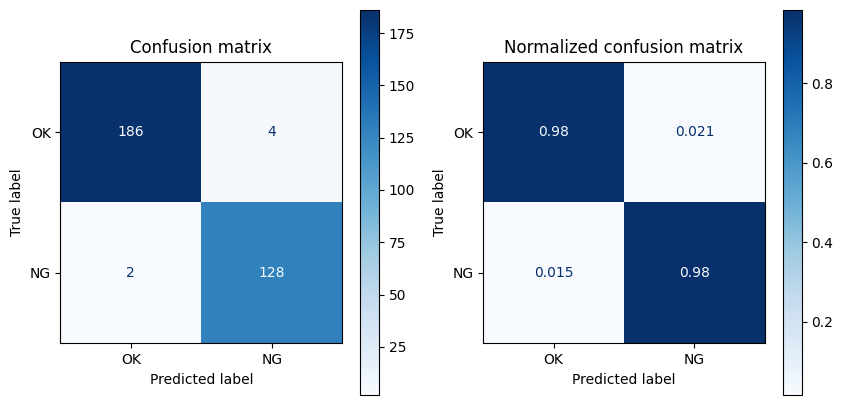

In [141]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 임계값 설정 및 이진 분류
threshold = 0.07076108
binarizer = Binarizer(threshold=threshold)
custom_prediction = binarizer.fit_transform(all_predictions_proba.reshape(-1, 1)).flatten()

# 평가 함수 호출
get_evaluation_by_custom_proba(all_targets, custom_prediction, visualize=True)